# Odometry Analysis

This notebook builds towards analyzing the accuracy of SLAM algorithms such as RTAB-Map.

## Manual coordinate transforms

arc1 and arc2 maps both refer to maps generated by `fiducial_slam` with the same tank configuration. The goal here is to select a common tag mapped as the origin, and have the maps "agree." We'll start with position (which I believe is as simple as subtraction) and then orientation (which I hope will be independent of position). 

In [12]:
import itertools
import matplotlib.pyplot as plt
import copy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

### Loading the data

In [132]:
def read_fiducialSLAM_map(map_file_path):
    # Define a dict to store the data for each fiducial
    fiducial_data = {}

    # Open the map file for reading
    with open(map_file_path, 'r') as map_file:
        for line in map_file:
            # Split the line into fields using whitespace as the delimiter
            fields = line.split()

            # Extract the first nine fields as the main data
            main_data = fields[:9]

            # The remaining fields (if any) belong to the links field
            links = fields[9:]

            # Extract the data from the main fields
            fiducial_id = int(main_data[0])
            x = float(main_data[1])
            y = float(main_data[2])
            z = float(main_data[3])
            
            # The "pan" "tilt" "roll" nomenclature in the fiducial_slam documentation
            # doesn't make much sense (when is the X axis ever "pan"?)
            #
            # But from the code, they're really rotation around x, y, z (in that order)
            # so this makes sense
            rx = np.deg2rad(float(main_data[4]))
            ry = np.deg2rad(float(main_data[5]))
            rz = np.deg2rad(float(main_data[6]))
            variance = float(main_data[7])
            num_observations = int(main_data[8])

            # Parse the links as a list of integers
            links = [int(link) for link in links]

            # Create a dictionary to store the fiducial data, including the links
            fiducial_info = {
                'id': fiducial_id,
                'x': x,
                'y': y,
                'z': z,
                'rx': rx,
                'ry': ry,
                'rz': rz,
                'variance': variance,
                'num_observations': num_observations,
                'links': links
            }

            # Append the dictionary to the fiducial_data list
            fiducial_data[fiducial_id] = fiducial_info

    return fiducial_data


In [133]:
# Parse through both fiducial_SLAM files
arc1 = read_fiducialSLAM_map("arc_1_map.txt")
arc2 = read_fiducialSLAM_map("arc_2_map.txt")

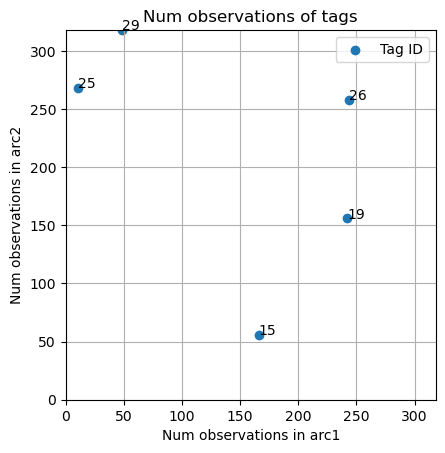

In [134]:
# Find the tag which would be a good origin
id_num_dict = {}
max_num = 1

def add_coord(arc):
    global id_num_dict
    global max_num
    for tag in arc.values():
        if tag['id'] not in id_num_dict.keys():
            id_num_dict[tag['id']] = [tag['num_observations']]
        else:
            id_num_dict[tag['id']].append(tag['num_observations'])
        max_num = max(max_num, tag['num_observations'])

add_coord(arc1)
add_coord(arc2)

for k in list(id_num_dict):
    v = id_num_dict[k]
    if len(v) != 2: 
        del id_num_dict[k]

# Plot the number of observations of each tag
data = id_num_dict
# Extract the IDs and coordinates from the dictionary
ids = list(data.keys())
coordinates = list(data.values())

# Split the coordinates into separate x and y lists
x_values, y_values = zip(*coordinates)

# Create a scatter plot
plt.scatter(x_values, y_values, label='Tag ID')

# Annotate the points with their IDs
for i, id in enumerate(ids):
    plt.annotate(str(id), (x_values[i], y_values[i]))

# Customize the plot with labels, titles, etc.
plt.xlabel('Num observations in arc1')
plt.ylabel('Num observations in arc2')
plt.title('Num observations of tags')

# Set aspect ratio to be equal
plt.xlim(0, max_num)
plt.ylim(0, max_num)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')


# Show the plot
plt.legend()
plt.grid(True)
plt.show()

### Using Klamp’t

In [135]:
import math
from klampt.math import vectorops,so3,se3

def tag_to_so3(tag):
    return so3.from_rpy((tag['rx'], tag['ry'], tag['rz']))
    
def tag_to_t(tag):
    return [tag['x'], tag['y'], tag['z']]

def tag_to_se3(tag):
    return (tag_to_so3(tag), tag_to_t(tag))


origin_tag = arc1[26]

T = tag_to_se3(origin_tag)

# Should equal zeros
print(se3.apply(se3.inv(T), t))

[0.0, 0.0, 0.0]


In [136]:
def transform_copy_arc(arc, origin_id): 
    origin_tag = arc[origin_id]

    T = tag_to_se3(origin_tag)
    T_inv = se3.inv(T)

    arc_transformed  = copy.deepcopy(arc)
    for k, v in arc_transformed.items():
        point = [v['x'], v['y'], v['z']]
        new_point = se3.apply(T_inv, point)
        v['x'] = new_point[0]
        v['y'] = new_point[1]
        v['z'] = new_point[2]
    return arc_transformed

def print_xyz(arc): 
    for k, v in arc.items():
        x = v['x']
        y = v['y']
        z = v['z']
        print(f'{k}: [{x}, {y}, {z}]')

In [137]:
# Arc 1: 
arc1_transformed = transform_copy_arc(arc1, 26)
print_xyz(arc1_transformed)

14: [-1.043304519633924, -0.19059585455921424, 1.1938743402847178]
15: [-1.122806044654784, 0.6684335403155831, 0.9691838539765583]
19: [-1.028064120352294, 0.011830235637865671, 0.7182300334920682]
25: [-0.09471876381460964, 0.6799168961412183, 0.05285613411065904]
26: [0.0, 0.0, 0.0]
29: [0.5121230361399577, -0.03881880878076405, 0.054781327919593004]


In [138]:
# Arc 2: 
arc2_transformed = transform_copy_arc(arc2, 26)
print_xyz(arc2_transformed)

15: [-1.1018315130573515, 0.6439621932794646, 0.9785663843288553]
19: [-1.037153295907975, 0.007315115914190651, 0.6993378808883344]
23: [-0.6079573335096221, -0.23414709981835674, 0.25493543218729475]
25: [-0.12456405843759014, 0.7025183825021581, 0.009372210310702789]
26: [0.0, 0.0, 0.0]
29: [0.5867209392555846, -0.048496349292058094, 0.11860594065386154]
31: [1.038699563123735, -0.11039842607849232, 0.4552363930222998]


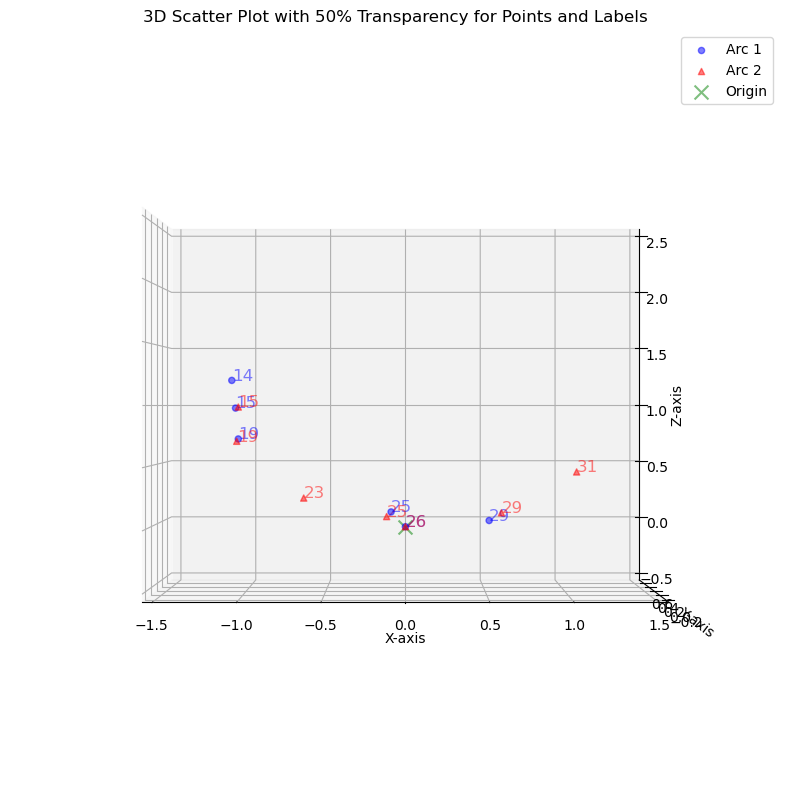

In [139]:
# graph both 
data1 = arc1_transformed
data2 = arc2_transformed

# Extract x, y, and z values and 'id' from the dictionaries
x_values1 = [item['x'] for item in data1.values()]
y_values1 = [item['y'] for item in data1.values()]
z_values1 = [item['z'] for item in data1.values()]
ids1 = list(data1.keys())

x_values2 = [item['x'] for item in data2.values()]
y_values2 = [item['y'] for item in data2.values()]
z_values2 = [item['z'] for item in data2.values()]
ids2 = list(data2.keys())

# Create a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plots for both data sets with 50% transparency
ax.scatter(x_values1, y_values1, z_values1, c='b', marker='o', label='Arc 1', alpha=0.5)
ax.scatter(x_values2, y_values2, z_values2, c='r', marker='^', label='Arc 2', alpha=0.5)

# Annotate the points with their 'id' for both data sets with 50% transparency
for i, id in enumerate(ids1):
    ax.text(x_values1[i], y_values1[i], z_values1[i], str(id), fontsize=12, color='b', alpha=0.5)
for i, id in enumerate(ids2):
    ax.text(x_values2[i], y_values2[i], z_values2[i], str(id), fontsize=12, color='r', alpha=0.5)

# Plot a marker at the origin (0, 0, 0) with 50% transparency
ax.scatter(0, 0, 0, c='g', marker='x', s=100, label='Origin', alpha=0.5)

# Customize the plot with labels and titles
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot with 50% Transparency for Points and Labels')
ax.set(xlim=(-1.5,1.5), zlim=(-0.5, 2.5))

# Set the viewpoint...
ax.view_init(0,-90)

# Show the plot with a legend
plt.legend()
plt.show()

## Evo

In [20]:
## evo_traj
from evo.tools import log
log.configure_logging()

from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

from evo.tools import file_interface
from evo.core import sync

In [21]:
from rosbags.rosbag1 import Reader as Rosbag1Reader
fiducial_bag = Rosbag1Reader("fiducial.bag")
fiducial_bag.open()
traj_ref = file_interface.read_bag_trajectory(fiducial_bag, "/fiducial_pose")

fiducial_older_bag = Rosbag1Reader("../fiducial_slam_simtime.bag")
fiducial_older_bag.open()
traj_est = file_interface.read_bag_trajectory(fiducial_older_bag, "/fiducial_pose")

# rtabmap_bag = Rosbag1Reader("rtabmap.bag")
# rtabmap_bag.open()
# traj_est = file_interface.read_bag_trajectory(rtabmap_bag, "/rtabmap/odom")


In [22]:
print(traj_ref)
print(traj_ref.get_infos())
print("-----------------")
print(traj_est)
print(traj_est.get_infos())

97 poses, 16.217m path length, 21.100s duration
{'nr. of poses': 97, 'path length (m)': 16.216590044434017, 'pos_start (m)': array([ 0.07116885,  0.01481873, -0.01458418]), 'pos_end (m)': array([ 0.46875961, -0.05870786,  0.57449082]), 'duration (s)': 21.099975109100342, 't_start (s)': 1689982591.2986026, 't_end (s)': 1689982612.3985777}
-----------------
97 poses, 16.217m path length, 21.100s duration
{'nr. of poses': 97, 'path length (m)': 16.216590044434017, 'pos_start (m)': array([ 0.07116885,  0.01481873, -0.01458418]), 'pos_end (m)': array([ 0.46875961, -0.05870786,  0.57449082]), 'duration (s)': 21.099975109100342, 't_start (s)': 1689982591.2986026, 't_end (s)': 1689982612.3985777}


In [23]:
# Rough way to crop the slightly longer bag file (est aka rtabmap) 
# to have the same number of poses as the shorter one
# Only for getting rough results
# traj_est.reduce_to_time_range(end_timestamp=1689982591.2986026 + (1689982612.3985777-1689982591.2986026)/132 * 98.5)
# print(traj_est)
# print(traj_est.get_infos())

### APE

In [24]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common
%matplotlib inline

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

### RPE

In [25]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

## Archived Code

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

import rosbag, rospy

# Given a text file of RTAB-Map poses, 
# returns a list containing (timestamp, position, quaternion, obj_id)
def read_rtabmap(filename):
    data = []
    with open(filename, "r") as file:
        lines = file.readlines()
        for line in lines[1:]:  # Skip the first line
            parts = line.strip().split()
            timestamp = float(parts[0])
            position = [float(p) for p in parts[1:4]]
            quaternion = [float(q) for q in parts[4:8]]
            # # obj_id is an RTAB-Map graph node, and is only useful for comparing RTAB-Map results 
            # obj_id = int(parts[8])
            # data.append((timestamp, position, quaternion, obj_id))
            data.append((timestamp, position, quaternion))
    return data

# Given a bagfile containing /fiducial_pose messages from fiducialSLAM, 
# returns a list containing (timestamp, position, quaternion)

def read_fiducialSLAM(bagfile):
    data = []
    bag = rosbag.Bag(bagfile)
    data = [(float(f"{timestamp.secs}.{(timestamp.nsecs + 500) // 1000:0d}"), 
           [message.pose.pose.position.x, message.pose.pose.position.y, message.pose.pose.position.z], 
           [message.pose.pose.orientation.x, message.pose.pose.orientation.y, message.pose.pose.orientation.z, message.pose.pose.orientation.w])
            for (topic, message, timestamp) in bag.read_messages(topics="/fiducial_pose")]
    return data